<div class="head0">
    <div class="head0__name">
        Diffusion equation with linear drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation by fast and accurate tensor based methods (1th order method) with linear drift (Ornstein–Uhlenbeck process).
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver3 import Solver3 as Solver

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider equation
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
$$
then we come to the multivariate Ornstein–Uhlenbeck process
$$
    d \, x(t) = A \left( \mu - x(t) \right) d \, t + S d \, \beta(t),
$$
where

- $x \in R^d$ is a stochastic process;

- $\beta \in R^q$ is a Brownian motion;

- $\mu \in R^{d}$ is the long-term mean;

- $A \in R^{d \times d}$ is the velocity (invertible real matrix);

- $S \in R^{d \times q}$ are the friction coefficients (positive real matrix).

It can be shown (see [Alternative way to derive the distribution of the multivariate Ornstein–Uhlenbeck process](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1)) that

- Mean vector
$
    M(t, x_0) = e^{-A t} x_0 + \left( I - e^{-A t} \right) \mu
$;

- Covariance matrix
$
    \Sigma(t) = \int_0^t e^{A (s-t)} S S^T e^{A^T (s-t)} d \, s
$;

- Transitional PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x - M(t, x_0))^T \Sigma^{-1}(t) (x - M(t, x_0))
        \right]
$.

- The (multivariate) Ornstein–Uhlenbeck process, at any time, is a (multivariate) normal random variable.

- The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if all eigenvalues of $A$ are positive (if $A > 0$ in the one dimensional case).

<div class="head2">
    <div class="head2__name">
        One dimensional case
    </div>
</div>

Let solve
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x),
$$
with
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
$$
where $A > 0$ is the velocity, $\mu$ is the long-term mean, $S > 0$ is the friction coefficient.

Let $\mu \equiv 0$ and $S \equiv 1$, then we have

- Mean value
$
    M(t, x_0) = e^{-A t} x_0
$;

- Covariance matrix
$
    \Sigma(t) = \frac{1 - e^{-2 A t}}{2 A} 
$;

- Transition PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        exp \left[
            -\frac{(x - M(t, x_0))^2}{2 \Sigma(t)}
        \right] =  
            \sqrt{
                \frac{A}{\pi \left( 1 - e^{-2 A t} \right)}
            }
            e^{\frac
                {-A \left( x - x_0 e^{-A t} \right)^2}
                {1 - e^{-2 A t}}
            }
$.

- Stationary PDF ($t \rightarrow \infty$)
$
    \rho_{\infty}(x) =  
        \sqrt{
            \frac{A}{\pi}
        }
        e^{-A x^2}
$.

- PDF
$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}
$  for initial condition
$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]}
$
(see proof below).

<div class="head2">
    <div class="head2__name">
        Analytic formula for PDF
    </div>
</div>

Let calculate PDF $\rho(x, t)$ at time $t$ in some spatial point $x$ using transition PDF $\rho(x, t, x_0)$
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}
        \right]},
$$
and fixed initial condition
$$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
$$
from equation
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0.
$$

We have
$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}  -\frac{x_0^2}{2 s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{s (x - e^{-A t} x_0)^2 + \Sigma(t) x_0^2}{2 \Sigma(t) s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                \frac{- s e^{-2 A t} x_0^2 + 2 s x e^{-A t} x_0 - \Sigma(t) x_0^2}{2 \Sigma(t) s}
            \right]}
            \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                - \frac{s e^{-2 A t} + \Sigma(t)}{2 \Sigma(t) s} x_0^2
                + \frac{x e^{-A t}}{\Sigma(t)} x_0
            \right]}
            \, d x_0,
$$

Since
$$
    \int_{-\infty}^{\infty} e^{-a x^2 + b x} \, d x =
        \sqrt{\frac{\pi}{a}} e^{\frac{b^2}{4a}},
    \quad
    a > 0,
$$
we come to
$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \sqrt{\frac{2 \pi \Sigma(t) s}{s e^{-2 A t} + \Sigma(t)}}
        \exp{\left[
            \frac{2 \Sigma(t) s x^2 e^{-2 A t}}{4 \Sigma^2(t) (s e^{-2 A t} + \Sigma(t))}
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s x^2 e^{-2 A t}
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            -
            \frac
                {
                    x^2
                }
                {
                    2 \Sigma(t)
                }
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s e^{-2 A t} - s e^{-2 A t} - \Sigma(t)
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            x^2
        \right]},
$$

$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}.
$$

In [9]:
A = 10.
m = 0. # Should be always zero!
s = 0.1

def func_f0(x, t):
    return A * (-1. * x + m)

def func_f1(x, t):
    return -1. * A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-1. * A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-0.5 * x**2 / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

In [10]:
t_poi = 1000
t_min = 0.
t_max = 0.1

x_poi = 500
x_min = -3.
x_max = +3.

<div class="head1">
    <div class="head1__name">
        Explicit solution
    </div>
</div>

We can solve it...

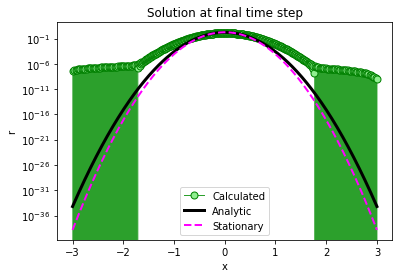

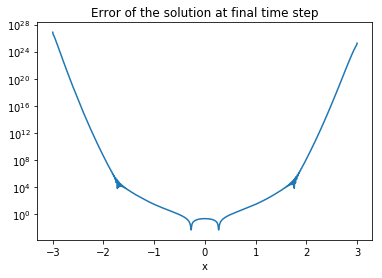

Number of time points    :      100
Number of spatial points :      500
Error (relative norm)    : 3.19e+24    
Total time (sec)         : 1.47e+00    


In [4]:
_time = time.time()

h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

n = x_poi
l = (x_max - x_min) / x_poi
X = np.linspace(x_min, x_max, x_poi)

I = np.eye(n)
Q_ = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q_ = (Q_ / 2 / l).toarray()
D_ = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D_ = (D_ / l / l).toarray()

def func_d(t, r):
    return D_ @ r

def func_q(t, r):
    f0 = func_f0(X, t)
    f1 = func_f1(X, t)
    return - f0 * (Q_ @ r) - r * f1

u = func_r0(X.reshape(1, -1))
for t in T[1:]:
    u0 = u
    w1 = solve_ivp(func_d, [t - h, t], u0).y[:, -1]
    u1 = solve_ivp(func_q, [t - h, t], w1).y[:, -1]
    #w2 = solve_ivp(func_q, [t - h, t], u0).y[:, -1]
    #u2 = solve_ivp(func_d, [t - h, t], w2).y[:, -1]
    #u = (u1 + u2) / 2
    u = u1
    
_time = time.time() - _time

u_calc = u
u_real = func_rt(X.reshape(1, -1), T[-1])
u_stat = func_rs(X.reshape(1, -1))

plt.plot(
    X, u_calc, label='Calculated',
    linewidth=1, color='tab:green', marker='o', markersize=7,
    markerfacecolor='lightgreen', markeredgecolor='g'
)
plt.plot(
    X, u_real, label='Analytic',
    linewidth=3, color='black'
)
plt.plot(
    X, u_stat, '--', label='Stationary',
    linewidth=2, color='magenta'
)
plt.semilogy()
plt.title('Solution at final time step')
plt.xlabel('x')
plt.ylabel('r')
plt.legend(loc='best')
plt.show()

e = np.abs((u_real - u_calc) / u_real)

plt.plot(X, e)
plt.semilogy()
plt.title('Error of the solution at final time step')
plt.xlabel('x')
plt.show()

print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%x_poi)
print('Error (relative norm)    : %-12.2e'%np.mean(e))
print('Total time (sec)         : %-12.2e'%_time)

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
</div>

In [11]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(t_poi, t_min, t_max)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()

Solve: 100%|███████| 999/999 [07:26<00:00,  2.33step/s, Norm 6.88e+00]


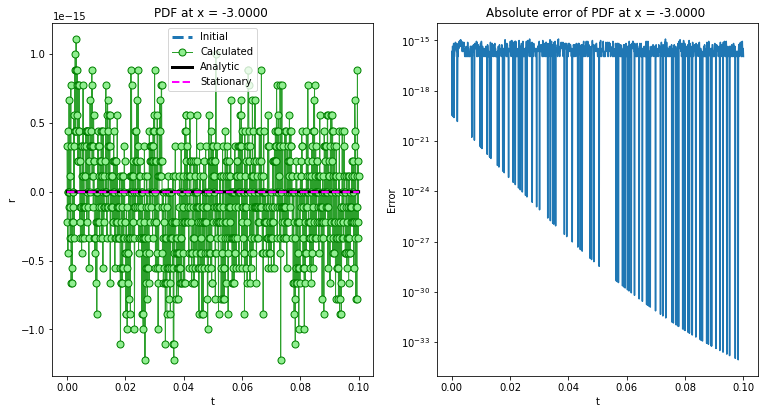

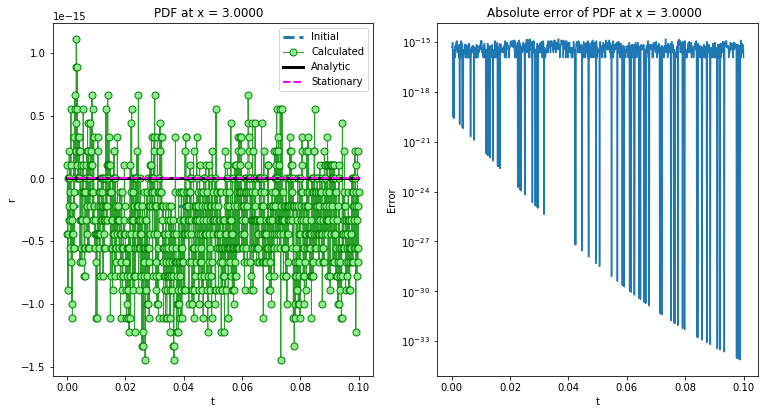

In [12]:
SL.plot_t(x=-3.0, is_err_abs=True)
SL.plot_t(x=+3.0, is_err_abs=True)

**Note** <span style="color: green;">Analytic solution is not vanish on the boundaries (the same is for the stationary solution will be zero), but is close to zero.<span>

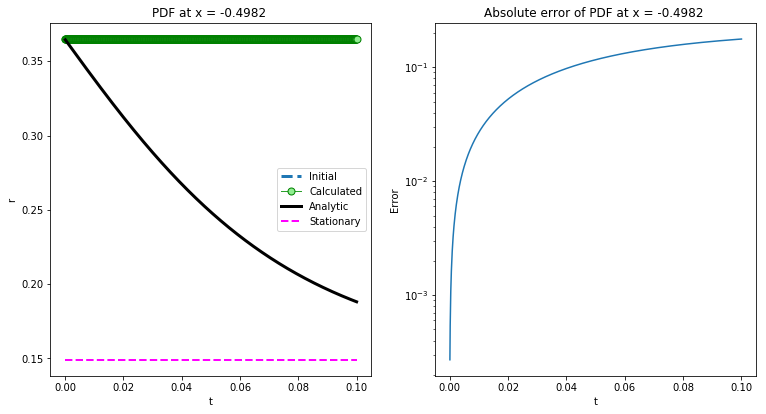

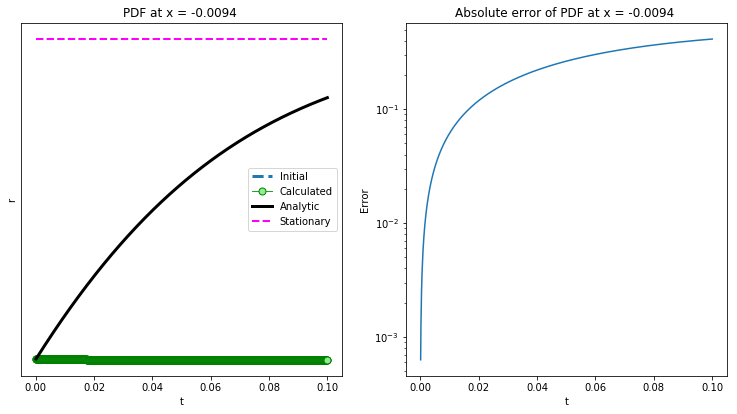

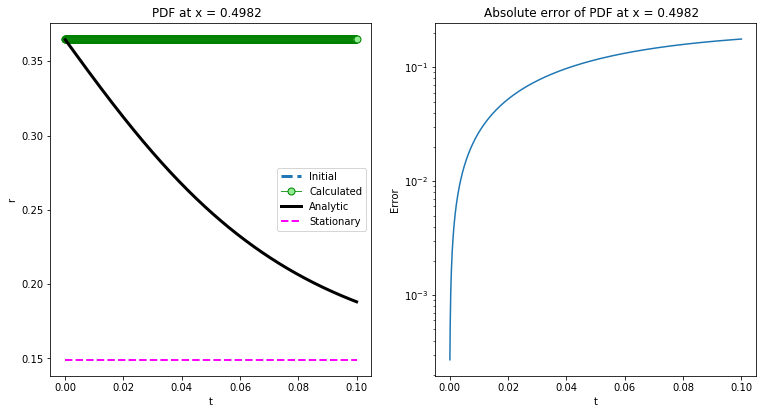

In [13]:
SL.plot_t(x=-0.5, is_err_abs=True)
SL.plot_t(x=+0.0, is_log=True, is_err_abs=True)
SL.plot_t(x=+0.5, is_err_abs=True)

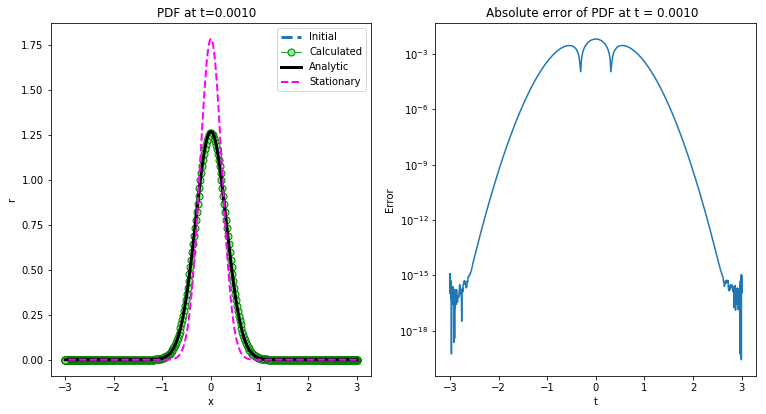

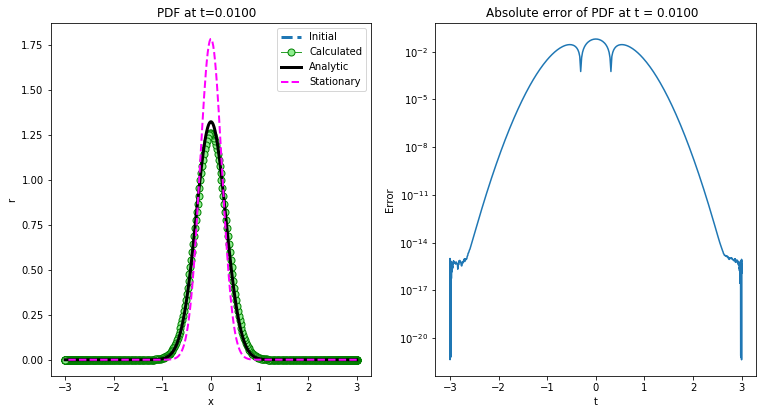

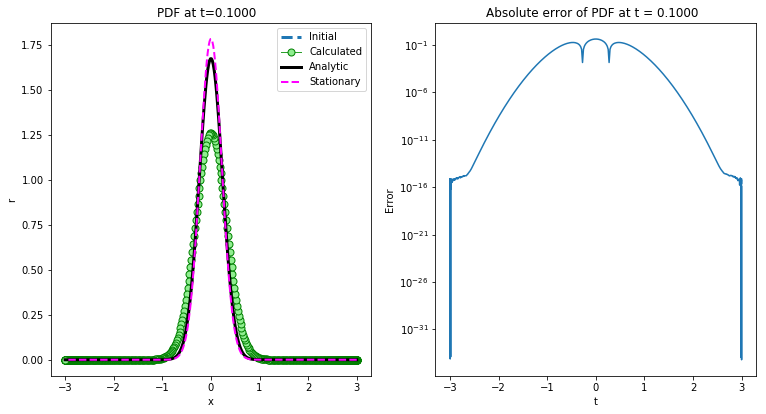

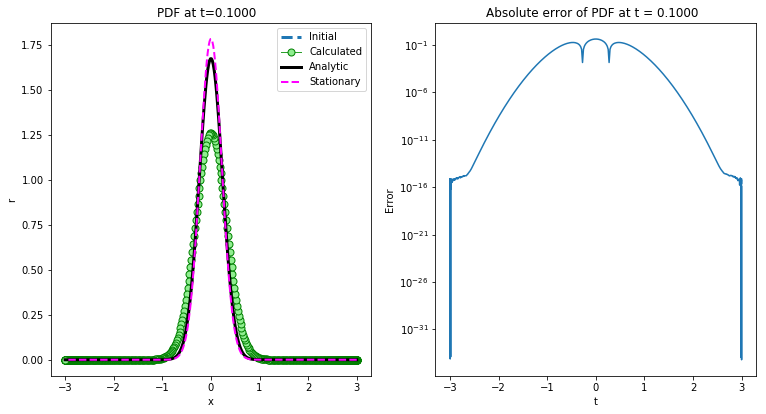

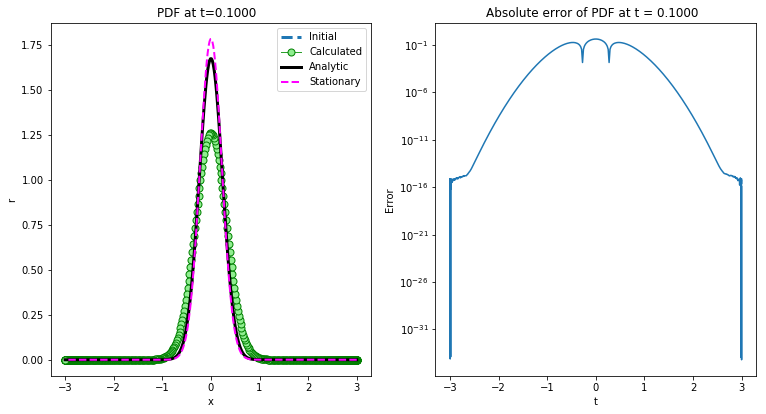

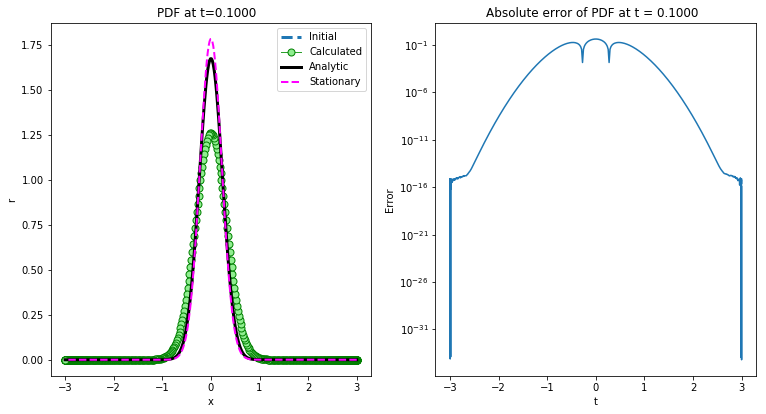

In [14]:
SL.plot_x(t=0.001, is_err_abs=True)
SL.plot_x(t=0.01, is_err_abs=True)
SL.plot_x(t=0.1, is_err_abs=True)
SL.plot_x(t=0.2, is_err_abs=True)
SL.plot_x(t=0.3, is_err_abs=True)
SL.plot_x(is_err_abs=True)

<div class="head1">
    <div class="head1__name">
        Convergence analysis
    </div>
</div>

In [9]:
N = [10, 50, 100, 200, 300, 400, 500, 1000, 2000]
E = []
T = []
for n in N:
    SL = Solver(d=1, with_tt=False)
    SL.set_grid_t(t_poi, t_min, t_max)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.prep()
    SL.calc()
    u_calc = SL.R[-1]
    u_real = func_rt(SL.X.reshape(1, -1), SL.T[-1])
    e = np.linalg.norm(u_real - u_calc) / np.linalg.norm(u_real)
    E.append(e)
    T.append([SL._t_prep, SL._t_calc])

Solve: 100%|███████| 999/999 [05:03<00:00,  2.79step/s, Norm 1.37e+01]


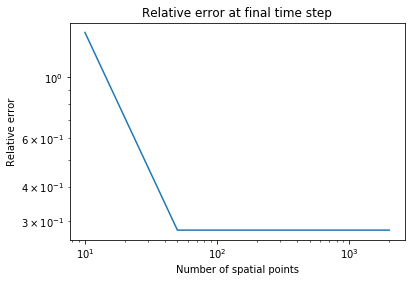



Solver info for n = 2000 : 
---------- Solver
Format   : 1D, NP
Grid x   : poi =      2000, min =   -3.0000, max =    3.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 1.41e+01, calc = 3.00e+02


In [10]:
plt.plot(N, E)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step')
plt.xlabel('Number of spatial points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d : '%N[-1])
SL.info()

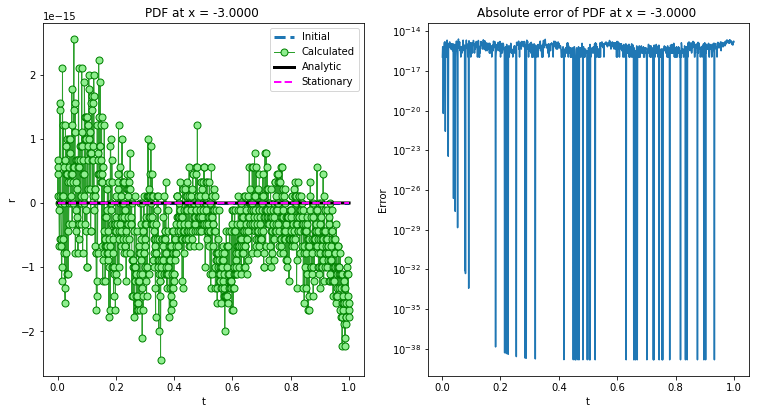

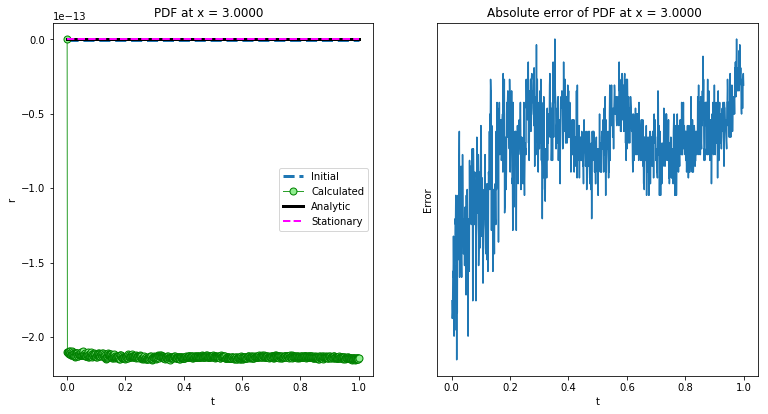

In [11]:
SL.plot_t(x=-3.0, is_err_abs=True)
SL.plot_t(x=+3.0, is_err_abs=True)

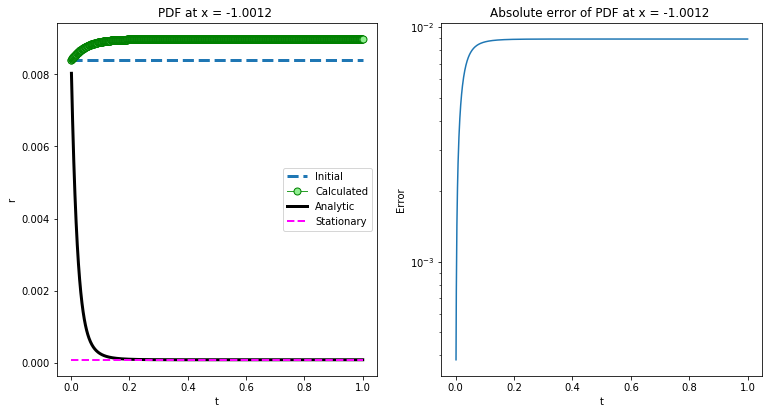

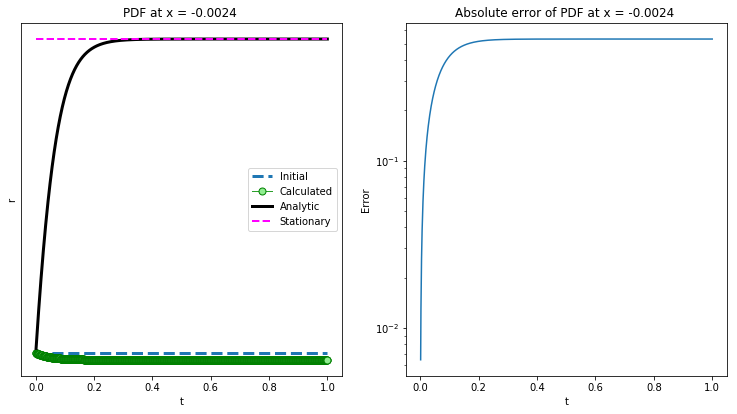

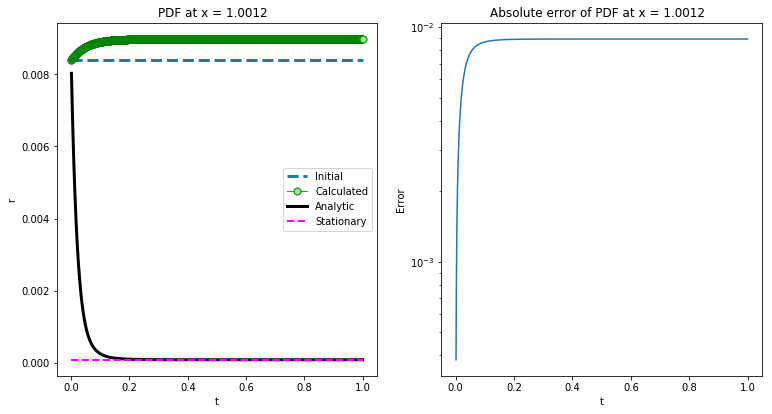

In [12]:
SL.plot_t(x=-1.0, is_err_abs=True)
SL.plot_t(x=+0.0, is_log=True, is_err_abs=True)
SL.plot_t(x=+1.0, is_err_abs=True)

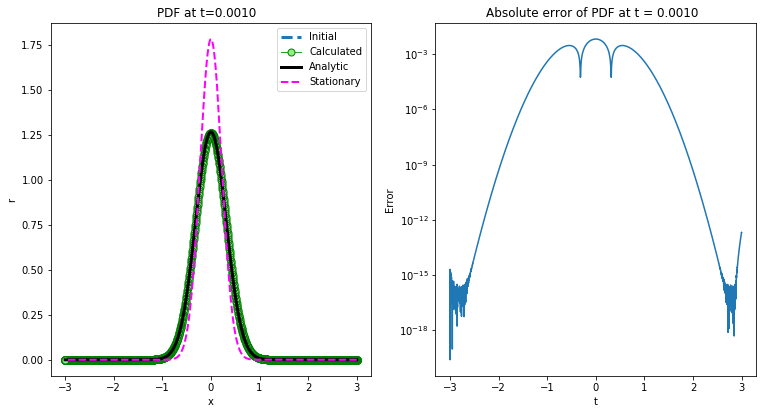

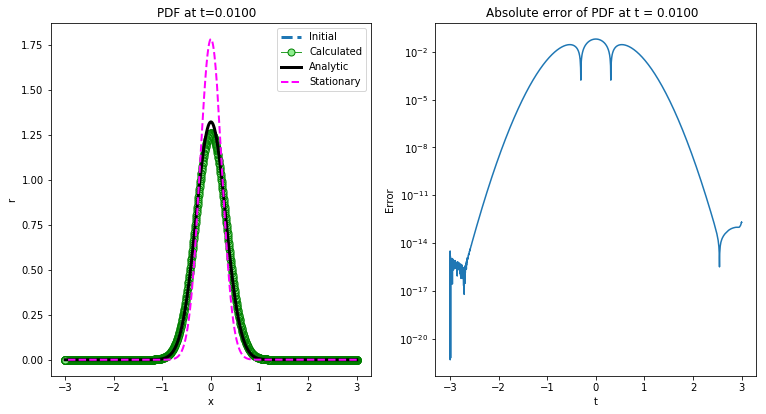

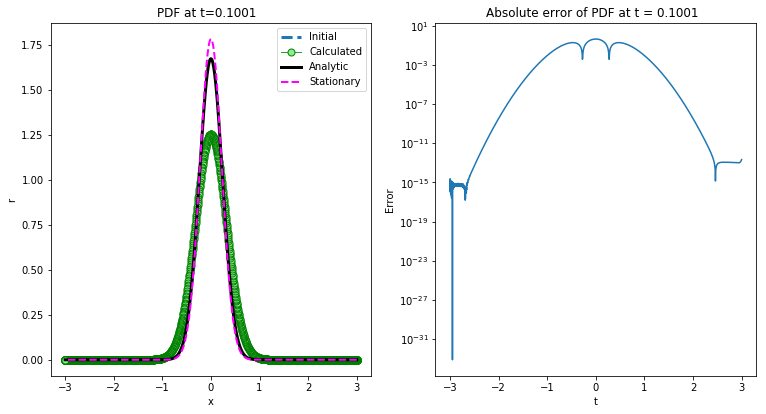

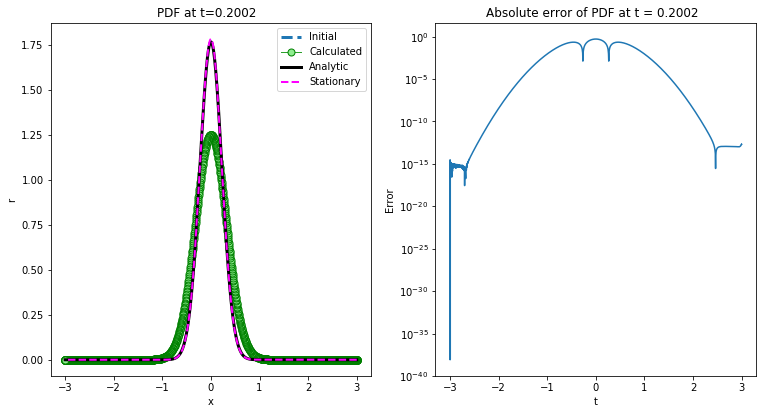

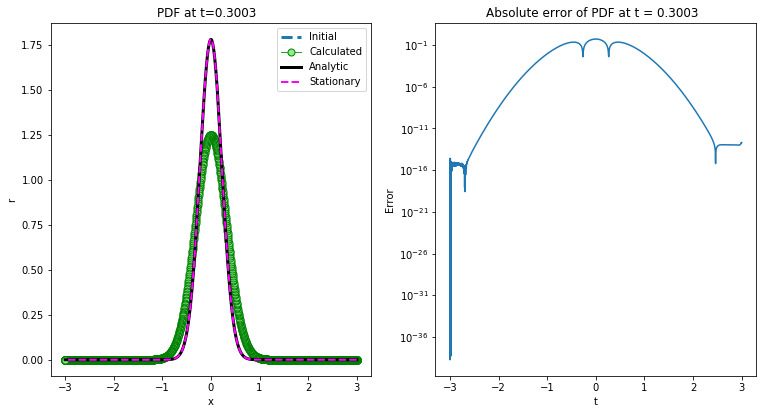

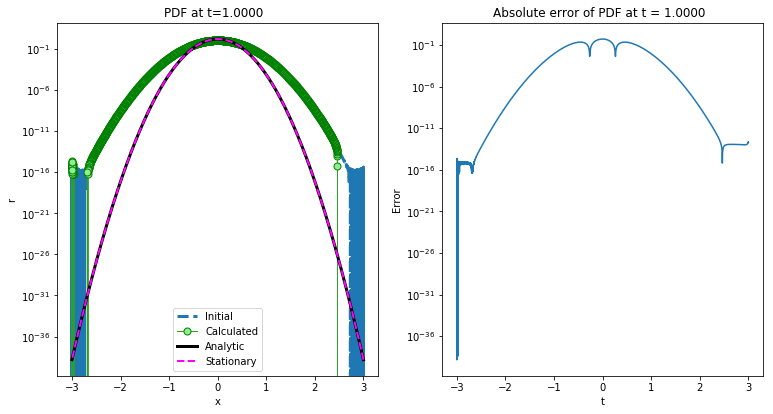

In [13]:
SL.plot_x(t=0.001, is_err_abs=True)
SL.plot_x(t=0.01, is_err_abs=True)
SL.plot_x(t=0.1, is_err_abs=True)
SL.plot_x(t=0.2, is_err_abs=True)
SL.plot_x(t=0.3, is_err_abs=True)
SL.plot_x(is_log=True, is_err_abs=True)

<div class="end"></div>